# Docummend - Academic Search

In [1]:
import os
import glob
import nltk
import spacy
import string
import gensim
import pypandoc
import pyLDAvis
import warnings
import shutil

import numpy  as np
import pandas as pd

import pyLDAvis.gensim_models as gensimvis
import gensim.corpora         as corpora
import matplotlib.pyplot      as plt

from data.functions import *

from gensim.corpora.dictionary import Dictionary
from gensim.test.utils         import datapath, common_texts

from wordcloud        import WordCloud
from nltk.corpus      import stopwords
from nltk.probability import FreqDist
from nltk.tokenize    import sent_tokenize, word_tokenize
from nltk.stem        import PorterStemmer, WordNetLemmatizer

from sklearn.neighbors               import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore")

## Training Data

### Creating DataFrame Of Clean Train Data

In [2]:
#clean_train_data('/Users/dimitrybelozersky/Documents/Phase5/all_decision_data_txt', 
#                '/Users/dimitrybelozersky/Documents/Phase5/data_csv/Decision_Database.csv')

## Target Data

### Converting Target Data From .Docx To Text

In [3]:
#docx_to_text('/Users/dimitrybelozersky/Documents/Phase5/target_files/Supp VBP- re Gordon Freedman MD copy.docx', 
#             '/Users/dimitrybelozersky/Documents/Phase5/target_files/Drew Benasillo v. Upper East Side Pain Medicine.txt')

### Creating DataFrame Of Clean Target Data

In [4]:
#clean_target('target_files/Drew Benasillo v. Upper East Side Pain Medicine.txt', 
#            '/Users/dimitrybelozersky/Documents/Phase5/data_csv/Target.csv')

## Data Instantiations And StopWords

### Train Data

In [5]:
df = pd.read_csv('data_csv/Decision_Database.csv', index_col=False)
df = df.drop(['Unnamed: 0', 'length'], axis=1)

### Target Data

In [6]:
Target = pd.read_csv('data_csv/Target.csv', index_col=False)
Target = Target.drop(['Unnamed: 0'], axis=1)

### StopWords Implementation

In [7]:
sw_list  = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ['©', '§', 'v.', '(see', 'The', 'Court,', 'New', 'York', 'In', 'Dept.', '1st',
            'A.D.2d', 'A.D.3d', 'N.Y.S.2d', 'N.Y.S.3d', 'N.E.2d', 'N.Y.2d']
sw_set   = set(sw_list)

## EDA

### Total Unique Words

In [8]:
data           = df['Decision']
decision_words = [d.split() for d in data.to_list()]
total_vocab    = set()
for word in decision_words:
    total_vocab.update([w.lower() for w in word])
print('Total Number Of Words In Train Set:\n' + str(len(total_vocab)))

Total Number Of Words In Train Set:
76099


#### Flatten Words For Word Frequancies

In [9]:
flat_words = [item.lower() for sublist in decision_words for item in sublist if item not in sw_list]
word_freq  = FreqDist(flat_words)

### Top 25 Words And Normalized Word Frequencies

In [10]:
total_word_count = sum(word_freq.values())
top_25_words     = word_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in top_25_words:
    normalized_frequency = word[1]/total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

plaintiff 		 0.009494
law 		 0.006771
motion 		 0.006479
judgment 		 0.006224
medical 		 0.006142
summary 		 0.006106
plaintiff's 		 0.005757
defendant 		 0.00457
court 		 0.00401
supreme 		 0.003878
action 		 0.003732
defendants 		 0.003514
order 		 0.003361
issue 		 0.00322
injury 		 0.003191
dismissing 		 0.003174
evidence 		 0.003091
injuries 		 0.002767
matter 		 0.002729
accident 		 0.00258
cause 		 0.002573
labor 		 0.002506
claim 		 0.00247
denied 		 0.002431
fact 		 0.002293


### Top 25 Words Word Cloud

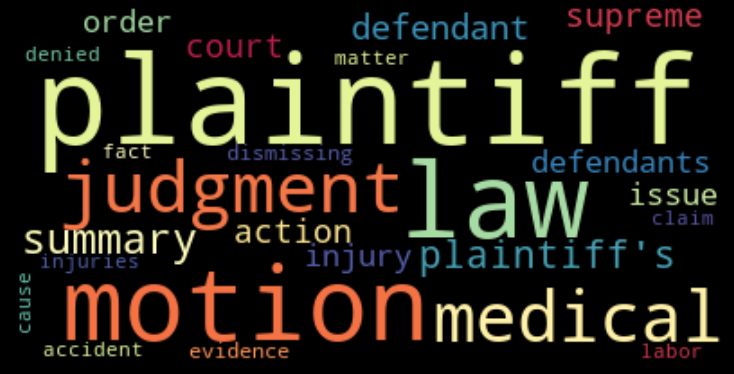

In [11]:
word_count      = [x[1] for x in top_25_words]
words           = [x[0] for x in top_25_words]
word_dictionary = dict(zip(words, word_count))

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(word_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Topic Modeling With LDA

#### LDA Train Data Topic Map

In [12]:
vis_train, lda_train = ldam(df['Decision'], 2)

In [13]:
vis_train

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.153864  0.0       1        1  52.241242
1     -0.153864  0.0       2        1  47.758758, topic_info=           Term          Freq         Total Category  logprob  loglift
329   defendant  15693.000000  15693.000000  Default  30.0000  30.0000
1794  plaintiff  18342.000000  18342.000000  Default  29.0000  29.0000
1132    serious  10174.000000  10174.000000  Default  28.0000  28.0000
669    judgment   8179.000000   8179.000000  Default  27.0000  27.0000
789      motion   8721.000000   8721.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1422     affirm   1741.109679   2844.980557   Topic2  -4.9740   0.2480
217       claim   1552.439901   2432.971395   Topic2  -5.0887   0.2897
188    category   1376.334414   2180.435076   Topic2  -5.2091   0.2789
340        deny   1692.173186   4613.451063   Topic2  -5.0025  -0.2640
1435     appeal   1624.267743   5537.510619   Topic2  -5.0434  -0.4875

[144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.346554        1st
1         2  0.653260        1st
21        1  0.352682   accident
21        2  0.647367   accident
30        1  0.999114     action
...     ...       ...        ...
1347      2  0.618024        use
1353      1  0.001065    vehicle
1353      2  0.998908    vehicle
1973      1  0.991993  violation
1973      2  0.009600  violation

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

#### LDA Target Data Topic % Match

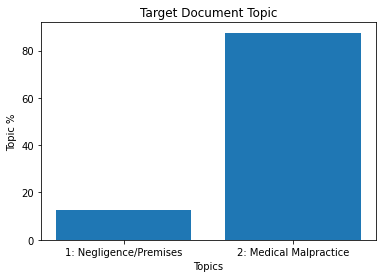

In [14]:
ldam_topics(Target['Text'], new_model=True, model=lda_train)

## Train Data SpaCy Vectorization

In [15]:
#spacy_train_data(df['Decision'], 'md', 
#                 '/Users/dimitrybelozersky/Documents/Phase5/data_csv/Train_spacy_out_md.csv')

## Modeling

### Nearest Neighbors - SpaCy Md Data


Top 5 Recommended Decisions - spacy:

1.  Snyder v State
2.  Vergine v Phillips
3.  Holland v Cayuga Medical Center at Ithaca Inc
4.  Page v Niagara Falls Memorial Medical Center
5.  Rojas v Tandon


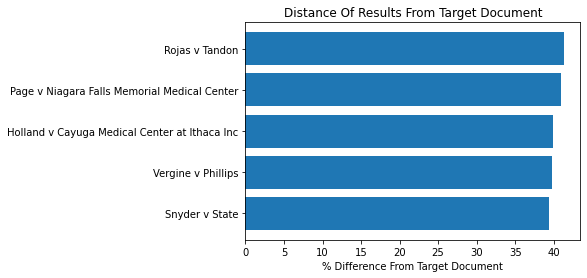

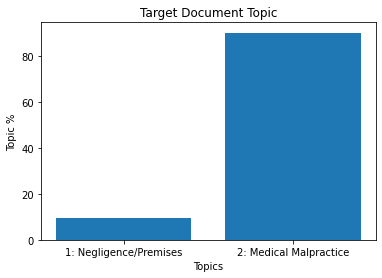

In [16]:
docummend(Target, 'spacy', 5, Topics=True)

### Nearest Neighbors - SpaCy Lg Data 


Top 5 Recommended Decisions - spacy lg:

1.  Vergine v Phillips
2.  Holland v Cayuga Medical Center at Ithaca Inc
3.  Rojas v Tandon
4.  Snyder v State
5.  Page v Niagara Falls Memorial Medical Center


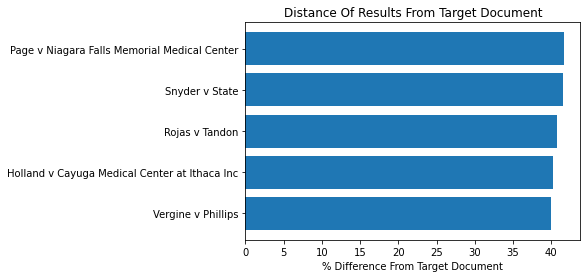

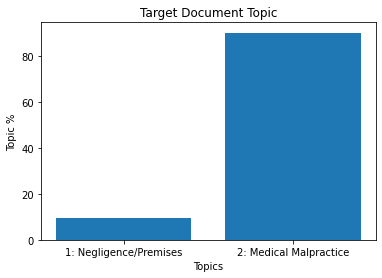

In [17]:
docummend(Target, 'spacy lg', 5, out=True, Topics=True)

### Nearest Neighbors - Tfidf Data


Top 5 Recommended Decisions - tfidf:

1.  Brito v Gomez
2.  Page v Niagara Falls Memorial Medical Center
3.  Como v Tomasky
4.  Bouzas v Schroeder
5.  Aviles v Morgan


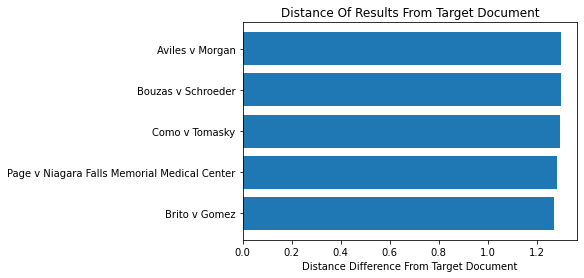

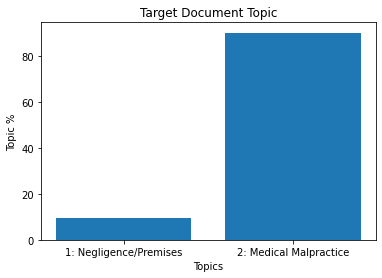

In [18]:
docummend(Target, 'tfidf', 5, Topics=True)

### Nearest Neighbors - Count Vectorizer Data


Top 5 Recommended Decisions - cv:

1.  Olivia R by Victoria R v Morris
2.  Smith v City of New York
3.  Pina v Arthur Clinton Housing Development Fund Corp
4.  Stagnitta v Ambrosino
5.  Smith v Lipsky


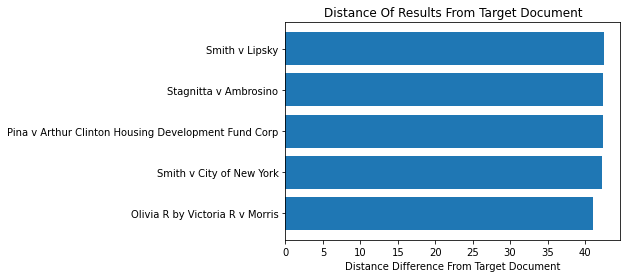

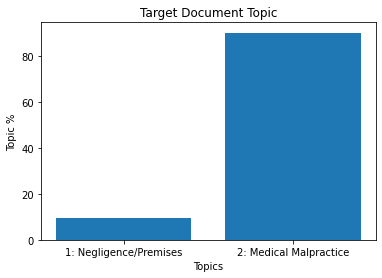

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.083557  0.055040       1        1  77.084845
4     -0.130670  0.025503       2        1  22.526806
1      0.016079 -0.026293       3        1   0.129450
3      0.014497 -0.026199       4        1   0.129450
0      0.016536 -0.028051       5        1   0.129449, topic_info=          Term       Freq      Total Category  logprob  loglift
44    judgment  11.000000  11.000000  Default  30.0000  30.0000
88    accident   9.000000   9.000000  Default  29.0000  29.0000
43       issue   7.000000   7.000000  Default  28.0000  28.0000
127       jury   7.000000   7.000000  Default  27.0000  27.0000
22   defendant  17.000000  17.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
295       find   0.003067   2.125550   Topic5  -5.7813   0.1084
214    testify   0.003066   3.023266   Topic5  -5.7816  -0.2441
89      action   0.003066   8.448034   Topic5  -5.7816  -1.2717
147     result   0.003065   5.543379   Topic5  -5.7818  -0.8506
140   pursuant   0.003065   3.580375   Topic5  -5.7820  -0.4136

[363 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
285       1  0.813185   147).where
0         1  0.991116          1st
220       1  0.293600       A.D.2d
220       2  0.587201       A.D.2d
221       1  0.511429       a.d.2d
...     ...       ...          ...
82        1  0.991116  unanimously
324       1  0.993397      vehicle
162       1  1.020225      verdict
167       1  0.991116         work
284       2  0.795572         year

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [19]:
docummend(Target, 'cv', 5, Topics=True, LDA=True)